# Rolling Planning mit Lateness (Tardiness + Earliness)

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import math
import pulp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 26)

import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.utils.rolling_scheduling as rolling_schedule

import src.models.heuristics.fcfs as heuristics
import src.models.cp.lateness as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation
import time

In [2]:
max_time = 60*30 # 30 min

In [3]:
data_path = get_path("data", "cp_lateness")
file_template = "02_{text}.csv"

## Generierung des Datensatzes für 18 Tage (Ankunft)

In [4]:
days_numb = 18

In [5]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "00_instance.csv")
df_ops, df_jobs = gen_jobs.create_jobs_for_days(df_instance, day_count = days_numb, u_b_mmax= 0.94, shuffle = True)
df_jobs

,Job,Arrival
0,Job_000,0.00
1,Job_001,81.32
2,Job_002,101.67
3,Job_003,142.01
4,Job_004,177.21
...,...,...
407,Job_407,25679.39
408,Job_408,25759.28
409,Job_409,25773.57
410,Job_410,25881.61


In [6]:
# a) Initialisierung der Deadlines
df_jobs = gen_deadline.get_times_df(df_ops, df_jobs, heuristics.schedule_fcfs_with_arrivals, target_service=1.0)

# Rundung für CP 
df_jobs["Arrival"] = np.floor(df_jobs["Arrival"]).astype(int)
df_jobs["Deadline"] = np.ceil(df_jobs["Deadline"]).astype(int)
df_jobs.head()

,Job,Arrival,Deadline
0,Job_000,0,2297
1,Job_001,81,3047
2,Job_002,101,3404
3,Job_003,142,3950
4,Job_004,177,2462


In [7]:
# b) Bestimmung der "Ready Time"
df_jobs['Ready Time'] = ((df_jobs['Arrival'] // 1440) + 1) * 1440

# c) Processing Time
processing_time = df_ops.groupby('Job')['Processing Time'].sum()
df_jobs = pd.merge(df_jobs, processing_time, on='Job')

# d) Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])

# e) Anpassung der Deadlines
min_slack = df_jobs['Slack'].min()

if min_slack < 180:
    extra_time = abs(min_slack) + 180 if min_slack < 0 else 180
    print(f"Der bisherige min. Slack: {min_slack}")
    df_jobs["Deadline"] = df_jobs["Deadline"] + extra_time

# f) erneute Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])
df_jobs 

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,2297,1440,395,462
1,Job_001,81,3047,1440,510,1097
2,Job_002,101,3404,1440,568,1396
3,Job_003,142,3950,1440,655,1855
4,Job_004,177,2462,1440,393,629
...,...,...,...,...,...,...
407,Job_407,25679,28813,25920,539,2354
408,Job_408,25759,29231,25920,597,2714
409,Job_409,25773,28913,25920,540,2453
410,Job_410,25881,28178,25920,395,1863


In [8]:
df_jobs['Slack'].mean()

np.float64(1770.868932038835)

In [9]:
df_jobs['Slack'].max()

np.int64(3137)

In [10]:
file = file_template.format(text= "all_jobs")
df_jobs.to_csv(data_path / file, index = False)

file = file_template.format(text= "all_ops")
df_ops.to_csv(data_path / file, index = False)

### Params

In [11]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


> Tag 0 wird nicht ausgeführt

## Tag 1 (init. Tag - kein Rescheduling)

In [12]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [14]:
# aktuelle Produktionaufträge
df_jobs_curr, df_ops_curr = gen_jobs.filter_ops_and_jobs_by_ready_time(df_jobs, df_ops, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,2297,1440,395,462
1,Job_001,81,3047,1440,510,1097
2,Job_002,101,3404,1440,568,1396
3,Job_003,142,3950,1440,655,1855
4,Job_004,177,2462,1440,393,629
...,...,...,...,...,...,...
27,Job_027,1390,4524,1440,539,2545
28,Job_028,1391,3688,1440,395,1853
29,Job_029,1410,3696,1440,393,1863
30,Job_030,1423,3720,1440,395,1885


### A) Scheduling

In [16]:
starting_time = time.time()

# Scheduling
df_plan = solver.solve_cp_jssp_lateness_by_tardiness_and_earliness(df_ops_curr, df_jobs_curr, w_t = 5,
                                                                schedule_start = 1440,
                                                                msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.28 Sekunden

Scheduling-Dauer: 0 Minuten und 0.39 Sekunden.


,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,2297,1440,29,1469,-828,0,828
1,Job_004,0,M2,177,2462,1440,14,1454,-1008,0,1008
2,Job_006,0,M1,299,2718,1440,46,1486,-1232,0,1232
3,Job_014,0,M2,537,2823,1454,14,1468,-1355,0,1355
4,Job_005,0,M2,240,3125,1468,84,1552,-1573,0,1573
...,...,...,...,...,...,...,...,...,...,...,...
315,Job_027,9,M3,1390,4524,4445,79,4524,0,0,0
316,Job_025,9,M4,1252,4555,4522,33,4555,0,0,0
317,Job_019,9,M5,808,4616,4573,43,4616,0,0,0
318,Job_023,9,M8,1211,4683,4609,74,4683,0,0,0


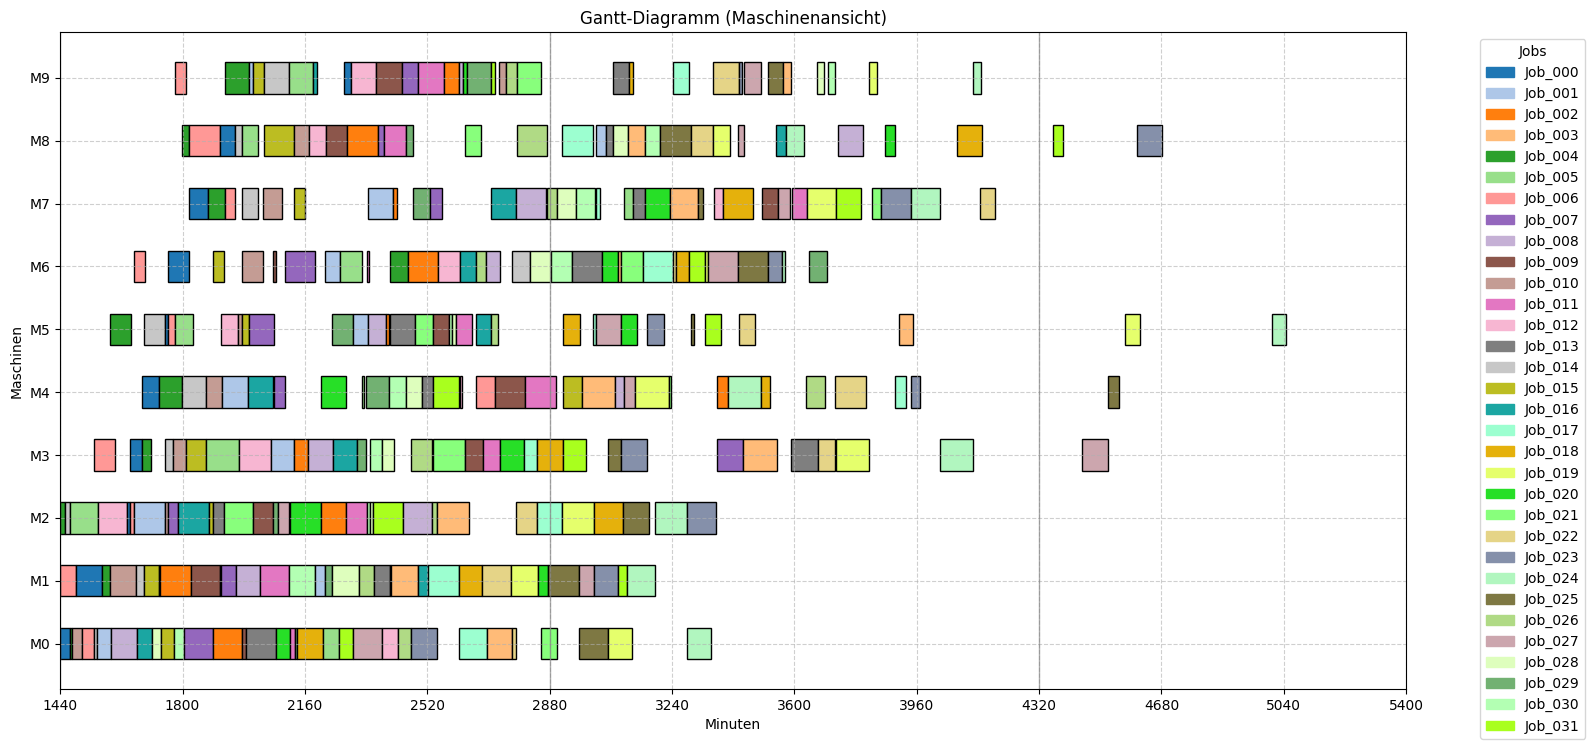

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [17]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [18]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              32
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64


In [19]:
file = file_template.format(text= f"plan_{day_numb:02d}_init")
file

'02_plan_01_init.csv'

In [20]:
df_plan.to_csv(data_path / file, index = False)

### B) Aufteilung in heutige und zukünftge Operationen

In [21]:
df_plan_for_sim = gen_jobs.filter_plan_for_today(df_plan, latest_op_start = day_end)
df_plan_for_sim

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,2297,1440,29,1469,-828,0,828
1,Job_000,4,M4,0,2297,1681,49,1730,-567,0,567
2,Job_000,5,M5,0,2297,1747,11,1758,-539,0,539
3,Job_000,6,M6,0,2297,1758,62,1820,-477,0,477
4,Job_000,7,M7,0,2297,1820,56,1876,-421,0,421
...,...,...,...,...,...,...,...,...,...,...,...
205,Job_030,5,M5,1423,3720,2583,11,2594,-1126,0,1126
206,Job_031,0,M0,1424,4390,2259,43,2302,-2088,0,2088
207,Job_031,3,M9,1424,4390,2708,11,2719,-1671,0,1671
208,Job_031,2,M4,1424,4390,2538,75,2613,-1777,0,1777


In [22]:
df_plan_waiting = gen_jobs.filter_plan_for_future(df_plan, earliest_op_start = day_end)
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_001,9,M8,81,3047,3017,30,3047,0,0,0
1,Job_002,9,M4,101,3404,3371,33,3404,0,0,0
2,Job_003,3,M4,142,3950,2974,99,3073,-877,0,877
3,Job_003,4,M6,142,3950,3081,9,3090,-860,0,860
4,Job_003,5,M8,142,3950,3110,52,3162,-788,0,788
...,...,...,...,...,...,...,...,...,...,...,...
105,Job_031,5,M1,1424,4390,3081,28,3109,-1281,0,1281
106,Job_031,6,M6,1424,4390,3291,46,3337,-1053,0,1053
107,Job_031,7,M5,1424,4390,3337,46,3383,-1007,0,1007
108,Job_031,8,M7,1424,4390,3723,72,3795,-595,0,595


In [23]:
file = file_template.format(text= f"plan_{day_numb:02d}_waiting")
file

'02_plan_01_waiting.csv'

In [24]:
df_plan_waiting.to_csv(data_path / file, index = False)

### C) Simulation

In [25]:
simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.25)
df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job_000 started on M0
[24:00:00] Job_004 started on M2
[24:00:00] Job_006 started on M1
[24:14:38] Job_004 finished on M2 (after 14 minutes 38 seconds)
[24:14:38] Job_014 started on M2
[24:19:58] Job_000 finished on M0 (after 19 minutes 59 seconds)
[24:29:00] Job_004 started on M0
[24:29:24] Job_014 finished on M2 (after 14 minutes 46 seconds)
[24:29:24] Job_005 started on M2
[24:35:25] Job_004 finished on M0 (after 06 minutes 26 seconds)
[24:35:25] Job_010 started on M0
[24:43:16] Job_006 finished on M1 (after 43 minutes 17 seconds)
[24:46:00] Job_000 started on M1
[25:10:39] Job_010 finished on M0 (after 35 minutes 14 seconds)
[25:10:39] Job_006 started on M0
[25:45:21] Job_005 finished on M2 (after 75 minutes 57 seconds)
[25:52:00] Job_012 started on M2
[25:54:06] Job_006 finished on M0 (after 43 minutes 27 seconds)
[25:54:06] Job_014 started on M0
[25:54:06] Job_006 started on M3
[26:01:01] Job_014 finished on M0 (after 06 minutes 55 seconds)
[26:01:01] Job_001 started o

In [26]:
df_execution

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,0,0,M0,1440.00,19.98,1459.98,1459.98
1,Job_000,1,0,M1,1486.00,93.25,1579.25,1579.25
2,Job_000,2,0,M2,1636.00,9.98,1645.98,1645.98
3,Job_000,3,0,M3,1650.80,27.84,1678.64,1678.64
4,Job_000,4,0,M4,1681.00,45.47,1726.47,1726.47
...,...,...,...,...,...,...,...,...
190,Job_030,5,1423,M5,2699.04,15.78,1291.82,2714.82
191,Job_031,0,1424,M0,2323.13,29.33,928.46,2352.46
192,Job_031,1,1424,M2,2360.00,76.09,1012.09,2436.09
193,Job_031,2,1424,M4,2593.44,43.99,1213.43,2637.43


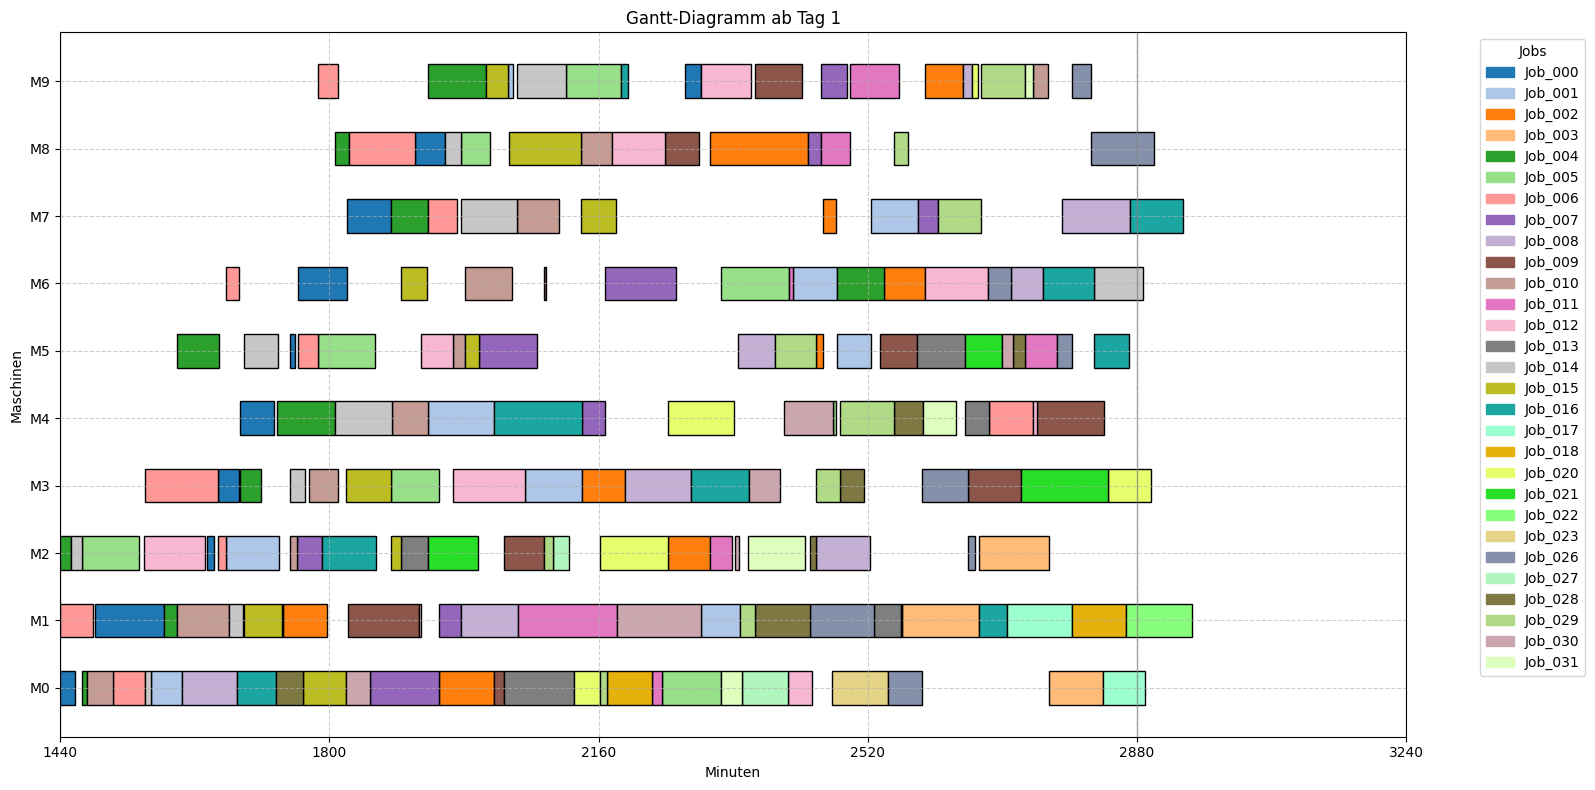

In [27]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [28]:
df_plan_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
7,Job_021,4,970,M8,2631,48
1,Job_011,7,498,M3,2683,52
5,Job_019,0,808,M1,2766,81
11,Job_022,1,1050,M0,2768,13
10,Job_022,2,1050,M2,2781,61
8,Job_021,5,970,M9,2783,72
3,Job_017,2,625,M3,2804,39
0,Job_011,8,498,M4,2808,90
14,Job_028,6,1391,M6,2823,62
2,Job_017,3,625,M2,2843,74


In [29]:
undone_numb = len(df_plan_undone)
print(f"Number of undone operations: {undone_numb}")

Number of undone operations: 15


In [30]:
file = file_template.format(text= f"execution_{day_numb:02d}")
file

'02_execution_01.csv'

In [31]:
df_execution.to_csv(data_path / file, index = False)

In [32]:
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
file

'02_plan_01_undone.csv'

In [33]:
df_plan_undone.to_csv(data_path / file, index = False)